In [1]:
# !pip install onnx onnxruntime
# !pip install validators matplotlib

In [2]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [3]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# resnet50.eval().to(device)

Using cache found in C:\Users\Berne/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/resnet50_pyt_amp/versions/20.06.0/files/nvidia_resnet50_200821.pth.tar" to C:\Users\Berne/.cache\torch\hub\checkpoints\nvidia_resnet50_200821.pth.tar
100%|██████████| 97.7M/97.7M [00:17<00:00, 5.83MB/s]
Using cache found in C:\Users\Berne/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [4]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    # 'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    # 'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    # 'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)



In [5]:
import onnxruntime as ort

torch.onnx.export(resnet50,               # model being run
                  batch,                         # model input (or a tuple for multiple inputs)
                  "resnet50.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Define the path where you want to save the file in Google Drive
# file_path = "/content/drive/My Drive/resnet50_single.onnx"

# torch.onnx.export(resnet50,               # model being run
#                   batch,                         # model input (or a tuple for multiple inputs)
#                   file_path,   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})

In [8]:
import time
with torch.no_grad():
    for i in range(6):
        startTime = time.time()
        output_py = resnet50(batch)
        stopTime = time.time()
        time_py = stopTime - startTime
        print(f"{time_py * 1000:0.3f}")
    
    # out_py = resnet50(batch)

    # output = torch.nn.functional.softmax(resnet50(batch), dim=1)

# print(batch) -> export this data to use in main.cpp

# results = utils.pick_n_best(predictions=output, n=5)

316.822
315.651
282.695
280.816
248.727
260.271


In [16]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("resnet50.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(batch)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(out_py), ort_outs[0], rtol=1e-03, atol=1e-3)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

output_onnx = torch.nn.functional.softmax(torch.from_numpy(ort_outs[0]), dim=1)

results_onnx = utils.pick_n_best(predictions=output_onnx, n=5)

Exported model has been tested with ONNXRuntime, and the result looks good!


In [ ]:
# import onnx_mlir_res...



In [ ]:
np.testing.assert_allclose(to_numpy(out_py), onnx_mlir_res, rtol=1e-03, atol=1e-3)

print("Exported model has been tested with ONNX-MLIR, and the result looks good!")

output_onnx_mlir = torch.nn.functional.softmax(torch.from_numpy(onnx_mlir_res), dim=1)

results_onnx_mlir = utils.pick_n_best(predictions=output_onnx, n=5)

In [10]:

# print(ort_outs[0])

sample 0: [('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]


In [11]:
print(results)

[[('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]]


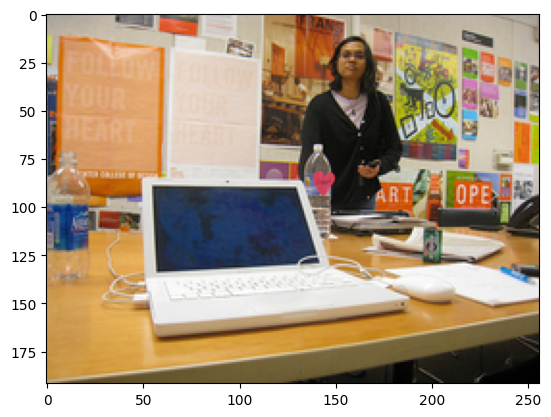

[('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]


In [12]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.LANCZOS)
    plt.imshow(img)
    plt.show()
    print(result)


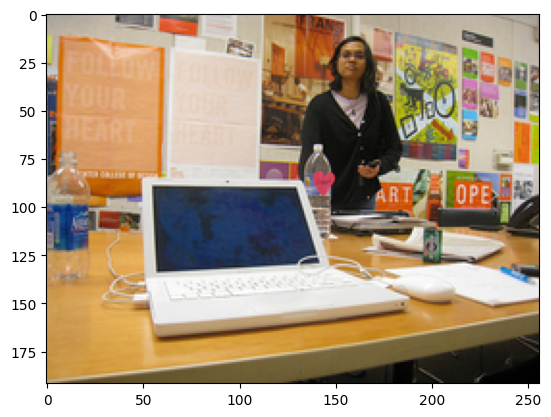

[('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]


In [13]:
for uri, result in zip(uris, results_onnx):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.LANCZOS)
    plt.imshow(img)
    plt.show()
    print(result)
